## Example: Working with models in Python

The main feature of HydroMT is to facilitate the process of building and analyzing spatial geoscientific models with a focus on water system models. It does so by automating the workflow to go from raw data to a complete model instance which is ready to run and to analyse model results once the simulation has finished. 

This notebook will explore how to work with HydroMT models in Python.

In [ ]:
# import hydromt and setup logging
import hydromt
from hydromt.log import setuplog

# other imports
import matplotlib.pyplot as plt
import geopandas as gpd

logger = setuplog("working with models", log_level=10)

### Available models in HydroMT

To know which models are available within your active environment, you can use global `MODELS` variable in hydromt

In [ ]:
# generic model classes
print(f"Generic model classes: {hydromt.MODELS.generic}")
# model classes from external plugin
print(f"Model classes from plugins: {hydromt.MODELS.plugins}")

Here you may only see the generic models ``grid_model``, ``lumped_model`` and ``network_model``. There is one more generic model within HydroMT ``mesh_model`` which is only available if the additional python mesh dependency *xugrid* is available in the activated environment.

### Model components

HydroMT defines any model through the model-agnostic Model API based on several *general* model components and *computational unit* components, see [Model API](https://deltares.github.io/hydromt/latest/user_guide/model_overview.html#model-api). Below is a scheme representing the Model API and general model classes available in HydroMT (without any plugin):

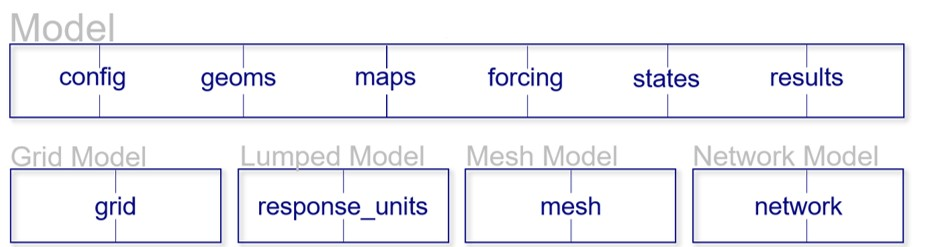

Let's discover how models are constructed within HydroMT and take the example of ``grid_model``. We will first instantiate a ``GridModel`` object called `mod`. 
The `api` property helps us discover the available components and their type. You can do the same with any other HydroMT Model class or plugin (give it a try!).

In [ ]:
mod = hydromt.GridModel()
mod.api

Here you see all the general components from the ``Model`` class like config, geoms, forcing etc. as well as the ``GridModel`` specific computational unit `grid`. 
You can see that most components are dictionaries of either xarray DataArray or Datasets or of geopandas GeoDataFrame. 
For now we are starting from an empty model so all these components will be empty but here is how you can access them:

In [ ]:
print(type(mod.grid))
mod.grid

In [ ]:
mod.geoms

### Model setup_* methods

To fill in our model components with data, HydroMT uses **setup_ methods**. These methods go from reading input data using the DataAdapter, transforming the data using workflows (e.g. reprojection, deriving model parameters, etc...) and adding the new model data to the right model component. An overview of available setup methods can be found in the API reference for the [GridModel](https://deltares.github.io/hydromt/latest/api.html#gridmodel), [LumpedModel](https://deltares.github.io/hydromt/latest/api.html#lumpedmodel), and [MeshModel](https://deltares.github.io/hydromt/latest/api.html#meshmodel)

Note that these methods for the generic model classes are still quite limited. To get an idea of potential setup_ methods, checkout the [model plugins](https://deltares.github.io/hydromt/latest/plugins.html)


Let's have a look at some examples of the *setup_* functions to start populating our model like ``setup_region``. This method parses the [HydroMT region option](https://deltares.github.io/hydromt/latest/user_guide/model_region.html) to define the geographic region of interest of the model to build and once done adds **region** into the `geoms` component. You can check the required arguments in the [docs](https://deltares.github.io/hydromt/latest/_generated/hydromt.Model.setup_region.html).

Let's now setup a region for our model using for example a subbasin for any point in the Piave basin. We first initialize a `GridModel` instance in writing mode at a model root folder. Data is sourced from the *artifact_data* catalog.

In [ ]:
root = "tmp_grid_model_py"
mod = hydromt.GridModel(
    root=root,
    mode="w",
    data_libs=["artifact_data", "vito_reclass.yml"],
    logger=logger,
)

In [ ]:
xy = [12.2051, 45.8331]
region = {"subbasin": xy, "strord": 7}
mod.setup_region(
    region=region,
    hydrography_fn="merit_hydro",
    basin_index_fn="merit_hydro_index",
)
mod.geoms["region"]

In [ ]:
# Plot
fig = plt.figure(figsize=(3, 4))
ax = plt.subplot()
mod.region.boundary.plot(ax=ax)
gdf_xy = gpd.GeoDataFrame(geometry=gpd.points_from_xy(x=[xy[0]], y=[xy[1]]), crs=4326)
gdf_xy.plot(ax=ax, markersize=40, c="red", zorder=2)

Similarly, we can also populate the **config** component using the ``setup_config`` method. For HydroMT **config** represents the configuration of the model kernel, e.g. the file that would fix your model kernel run settings or list of outputs etc. For most models, this is usually a text file (for exemple .ini, .toml, .inp formats) that can be ordered in sections. Within HydroMT we then use the dictionnary object to represent each header/setting/value.

Let's populate our config with some simple settings:

In [ ]:
config = {
    "header": {"setting": "value"},
    "timers": {"start": "2010-02-05", "end": "2010-02-15"},
}

mod.setup_config(**config)
mod.config

We can setup map data using the ``setup_maps_from_raster`` and ``setup_maps_from_raster_reclass`` methods. Both methods add data to the **maps** component based on input raster data (RasterDataset type), but the second method additionally reclassifies the input data based on a reclassification table. The **maps** component gathers any raster input data without any requirements for a specific grid (CRS and resolution). It can contain, for example, direct model input data for models like Delft3D-FM that will interpolate input data on the fly to the model mesh, or auxiliary data that are not used by the model kernel but can be used by HydroMT to build the model (e.g. a gridded DEM), etc.

For models that require all their input data to be resampled to the exact computation grid (all raster at the same resolution and projection), then the input data would go into the **grid** component. The corresponding *setup_* functions for the **grid** components are under development.

But back to our example, let's add both a DEM map from the data source *merit_hydro_1k* and a manning roughness map based on reclassified landuse data from the *vito* dataset. 

In [ ]:
mod.setup_maps_from_raster(
    raster_fn="merit_hydro_1k",
    variables="elevtn",
    fill_method=None,
    reproject_method=None,
)
_ = mod.setup_maps_from_raster_reclass(
    raster_fn="vito",
    reclass_table_fn="vito_reclass",  # Note: from local data catalog
    reclass_variables=["manning"],
)

In [ ]:
# check which maps are read
print(f"model maps: {list(mod.maps.keys())}")

mod.maps["manning"]

In [ ]:
# Plot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
mod.maps["elevtn"].raster.mask_nodata().plot(ax=axes[0], cmap="terrain")
mod.region.boundary.plot(ax=axes[0], color="k")
gdf_xy = gpd.GeoDataFrame(geometry=gpd.points_from_xy(x=[xy[0]], y=[xy[1]]), crs=4326)
gdf_xy.plot(ax=axes[0], markersize=40, c="red", zorder=2)
axes[0].set_title("Elevation")

mod.maps["manning"].plot(ax=axes[1], cmap="viridis")
mod.region.boundary.plot(ax=axes[1], color="k")
gdf_xy.plot(ax=axes[1], markersize=40, c="red", zorder=2)
axes[1].set_title("Manning roughness")

### Model read & write methods

Once our model is filled up with data, we can then write it down using either the general ``write`` method or component specific *write_* methods. Similarly, our model can be read back with the general ``read`` method or component specific ones.

Let's now write our model into a model root folder. 

In [ ]:
mod.write(components=["maps", "geoms", "config"])

In [ ]:
# print MODEL_ROOT folder
import os


def print_dir(root):
    for path, _, files in os.walk(root):
        print(path)
        for name in files:
            if name.endswith(".xml"):
                continue
            print(f" - {name}")


print_dir(root)

And now let's read it back in a new `GridModel` instance:

In [ ]:
mod2 = hydromt.GridModel(root=root, mode="r", logger=logger)
mod2.read(components=["config", "geoms", "maps"])

In [ ]:
# check which maps are read
print(f"model maps: {list(mod2.maps.keys())}")

### Building / updating a model with python

Using the same functionalities, it is also possible to build or update a model within python instead of using the command line, using the ``build`` and ``update`` methods. Let's see how we could rebuild our previous `GridModel` with the ``build`` method.

First let's start with writing a HydroMT build configuration (ini-file) with the GridModel (setup) methods we want to use.

In [ ]:
from hydromt.config import configread
from pprint import pprint

# Read the build configuration
config = configread("grid_model_build.ini")
pprint(
    config,
)

And now let's build our model:

In [ ]:
# First we instantiate GridModel with the output folder and use the write mode (build from scratch)
root3 = "tmp_grid_model_py1"
mod3 = hydromt.GridModel(
    root=root3,
    mode="w",
    data_libs=["artifact_data", "vito_reclass.yml"],
    logger=logger,
)

# Now let's build it with the config file
mod3.build(region=region, opt=config)

In [ ]:
print_dir(root3)

And check that the results are similar to our one-by-one setup earlier:

In [ ]:
mod3.config

In [ ]:
# Plot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
mod3.maps["elevtn"].raster.mask_nodata().plot(ax=axes[0], cmap="terrain")
mod3.region.boundary.plot(ax=axes[0], color="k")
axes[0].set_title("Elevation")

mod3.maps["manning"].plot(ax=axes[1], cmap="viridis")
mod3.region.boundary.plot(ax=axes[1], color="k")
axes[1].set_title("Manning roughness")